#### This is using Keras
The data is a sine wave  
Tutorial comes from here: https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction

###### TODO  
Try Seasonality time series  
Try OutFront Media data  
Try normalizing the input  
Try tweaking the parameters

In [1]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential
from calcMAPE import calcMAPE
from numpy import newaxis

Using TensorFlow backend.


In [2]:
def getData(config):
    return pd.read_csv(config["dataLoc"]+config["fileName"])

In [3]:
def getConfig():
    config={}
    config["dataLoc"] = "/home/tbrownex/data/LSTMtutorial/"
    config["fileName"] = "sinewave.csv"
    config["batchSize"] = 32
    config["segmentLength"] = 50
    config["epochs"] = 3
    config["testPct"] = 0.2
    return config

In [4]:
def prepData(df):
    '''
    Make sure the number of entries in the DF is a multiple of the segment Length
    '''
    extra = df.shape[0] % config["segmentLength"]
    if extra > 0:
        df = df[:-extra]
        print("{} rows removed".format(extra))
    return np.array(df["sinewave"])

In [5]:
def formatKeras(df):
    ''' Incoming data is 1D. Put it into 3D for keras where:
         2nd and 3rd dimensions are a plane with shape [segmentLength, 1]
         Stack the planes to make the 1st dimension.
         Each plane is the previous plane shifted by 1 byte.
         Skim off the last element in each plane (byte 50) for the label (y), 
         leaving 49 elements behind
         '''
    segments = []
    offset = 0
    while offset < (df.shape[0] - config["segmentLength"]):
        segment = df[offset:offset+config["segmentLength"]]
        segment = np.reshape(segment, newshape=[config["segmentLength"], 1])
        segments.append(segment)
        offset += 1
    arr = np.array(segments)
    x = arr[:, :-1]
    y = arr[:, -1, [0]]
    return x, y

In [6]:
def fitModel(model, config):
    m = model.fit(
        trainX,
        trainY,
        verbose=0,
        epochs= config["epochs"],
        batch_size = config["batchSize"])
    return m.history["loss"][0]

In [7]:
def addLayers(model, width):
    input_dim = 1
    return_seq = False
    use_bias = True
    bias_initializer="tom"
    L1size = 100
    L1act = "tanh"
    
    model.add(LSTM(units=L1size,
                   activation=L1act,
                   input_shape=(width, input_dim),
                   return_sequences=return_seq))
    model.add(Dense(1, activation="linear"))
    return model

In [8]:
def getPredictions(testX, testY):
    # The idea here is to get an initial segment to use for prediction. testX[0] is one segmentLength
    # After that, replace the testX with predicted values, one at a time
    testSeg = testX[0]
    testSeg = testSeg[newaxis,:,:]    # Needs to be 3D

    # Make the predictions
    predictions = []
    for _ in range(testY.shape[0]):
        pred = model.predict(testSeg, batch_size=1)[0][0]
        predictions.append(pred)
        # Shift the test segment one to the left and replace the rightmost value with the prediction
        testSeg = np.roll(testSeg, -1)
        testSeg[0,-1,0] = pred
    return predictions

In [9]:
config = getConfig()
df = getData(config)
arr = prepData(df)

print("Before formatting, data has shape: {}".format(arr.shape))
X,Y = formatKeras(arr)
print("After formatting, X has shape: {} and Y {}".format(X.shape, Y.shape))

testCount = int(X.shape[0]*(config["testPct"]))
trainX = X[:-testCount]
trainY = Y[:-testCount]
testX = X[-testCount:]
testY = Y[-testCount:]

1 rows removed
Before formatting, data has shape: (5000,)
After formatting, X has shape: (4950, 49, 1) and Y (4950, 1)


In [10]:
width = trainX.shape[1]
model = Sequential()
model = addLayers(model, width)
model.compile(loss="mse", optimizer="adam")
fitModel(model, config)
predictions = getPredictions(testX, testY)

# calculate the error
n = 100
mape = calcMAPE(testY[:n,0], np.array(predictions[:n]))
print("MAPE for the first {} predictions is {:.2%}".format(n, mape))

MAPE for the first 100 predictions is 2.06%


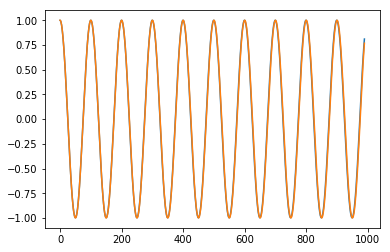

In [12]:
import matplotlib.pyplot as plt
plt.plot(predictions)
plt.plot(testY[:,0])
plt.show()